**Earthquake Aftershock Prediction**

This repository contains a deep learning-based framework designed to predict aftershocks following a main earthquake. The model combines Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks to analyze spatial and temporal patterns in seismic data, offering enhanced accuracy over traditional prediction methods.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [5]:
data=pd.read_csv('/content/drive/MyDrive/datascience/earthquake_data.csv')

In [6]:
data.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


In [7]:
# date_time column in the DataFrame data is converted to a datetime type
data['date_time']=pd.to_datetime(data['date_time'])

<ipython-input-7-c81af5c6153f>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date_time']=pd.to_datetime(data['date_time'])


In [8]:
# ''' The code identifies and labels aftershocks occurring within 24 hours after the mainshock.
# The aftershock_occurred column is created to indicate whether each event is an aftershock (1) or not (0).'''
mainshock_time=data['date_time'].min()
threshold_hours=24
data['aftershock_occurred']=((data['date_time'] > mainshock_time) &
                               (data['date_time'] <= mainshock_time + pd.Timedelta(hours=threshold_hours)))
data['aftershock_occurred']=data['aftershock_occurred'].astype(int)
labels=data['aftershock_occurred'].values
print(data[['date_time', 'aftershock_occurred']].head())

            date_time  aftershock_occurred
0 2022-11-22 02:03:00                    0
1 2022-11-18 13:37:00                    0
2 2022-11-12 07:09:00                    0
3 2022-11-11 10:48:00                    0
4 2022-11-09 10:14:00                    0


In [9]:
# Calculate time since mainshock in seconds
data['time_since_mainshock']=(data['date_time'] - data['date_time'].min()).dt.total_seconds()
# Calculate differences from the mean for latitude, longitude, and depth
data['latitude_diff']=data['latitude'] - data['latitude'].mean()
data['longitude_diff']=data['longitude'] - data['longitude'].mean()
data['depth_diff']=data['depth'] - data['depth'].mean()
print(data)

                                                 title  magnitude  \
0         M 7.0 - 18 km SW of Malango, Solomon Islands        7.0   
1             M 6.9 - 204 km SW of Bengkulu, Indonesia        6.9   
2                                             M 7.0 -         7.0   
3                  M 7.3 - 205 km ESE of Neiafu, Tonga        7.3   
4                                             M 6.6 -         6.6   
..                                                 ...        ...   
777  M 7.7 - 28 km SSW of Puerto El Triunfo, El Sal...        7.7   
778              M 6.9 - 47 km S of Old Harbor, Alaska        6.9   
779             M 7.1 - 16 km NE of Port-Olry, Vanuatu        7.1   
780                      M 6.8 - Mindanao, Philippines        6.8   
781           M 7.5 - 21 km SE of Lukatan, Philippines        7.5   

              date_time  cdi  mmi  alert  tsunami  sig net  nst  ...  \
0   2022-11-22 02:03:00    8    7  green        1  768  us  117  ...   
1   2022-11-18 13:37:00    

In [10]:
scaler=MinMaxScaler()
data[['magnitude', 'time_since_mainshock', 'latitude_diff', 'longitude_diff', 'depth_diff']] = scaler.fit_transform(data[['magnitude', 'time_since_mainshock', 'latitude_diff', 'longitude_diff', 'depth_diff']])

In [11]:
features=data[['magnitude', 'time_since_mainshock', 'latitude_diff', 'longitude_diff', 'depth_diff']].values
labels=data['aftershock_occurred'].values

In [12]:
n_input=10
n_features=features.shape[1]

In [14]:
def create_sequences(data, n_time_steps):
    sequences=[]
    labels=[]
    for i in range(len(data)-n_time_steps):
        sequences.append(data[i:i+n_time_steps])
        labels.append(data[i+n_time_steps][0])
    return np.array(sequences),np.array(labels)
X, y=create_sequences(features,n_input)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (772, 10, 5)
Shape of y: (772,)


In [24]:
X, y=create_sequences(features, n_input)

In [25]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (772, 10, 5)
Shape of y: (772,)


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            17920     
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33489 (130.82 KB)
Trainable params: 33489 (130.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Shape of X_train:", X_train.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of y_test:", y_test.shape)
X_train.shape

In [33]:
X_test.shape

(155, 10, 5)

In [34]:
y_train.shape

(617,)

In [35]:
y_test.shape

(155,)

In [20]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 12s 113ms/step - loss: 0.5924 - accuracy: 0.1643 - val_loss: 0.4629 - val_accuracy: 0.1371
Epoch 2/10
16/16 [==============================] - 0s 24ms/step - loss: 0.4512 - accuracy: 0.1805 - val_loss: 0.4607 - val_accuracy: 0.1371
Epoch 3/10
16/16 [==============================] - 0s 19ms/step - loss: 0.4495 - accuracy: 0.1805 - val_loss: 0.4567 - val_accuracy: 0.1371
Epoch 4/10
16/16 [==============================] - 0s 19ms/step - loss: 0.4485 - accuracy: 0.1805 - val_loss: 0.4570 - val_accuracy: 0.1371
Epoch 5/10
16/16 [==============================] - 0s 24ms/step - loss: 0.4488 - accuracy: 0.1805 - val_loss: 0.4569 - val_accuracy: 0.1371
Epoch 6/10
16/16 [==============================] - 0s 19ms/step - loss: 0.4490 - accuracy: 0.1805 - val_loss: 0.4567 - val_accuracy: 0.1371
Epoch 7/10
16/16 [==============================] - 0s 19ms/step - loss: 0.4485 - accuracy: 0.1805 - val_loss: 0.4567 - val_accuracy: 0.1371
Epoch 8/10


In [21]:
loss, accuracy=model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

5/5 [==============================] - 0s 8ms/step - loss: 0.4747 - accuracy: 0.1613
Test Loss: 0.4746584892272949, Test Accuracy: 0.16129031777381897


In [22]:
predictions=model.predict(X_test)
predicted_classes=(predictions > 0.5).astype(int)
print("Predictions:")
print(predicted_classes)

5/5 [==============================] - 1s 6ms/step
Predictions:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


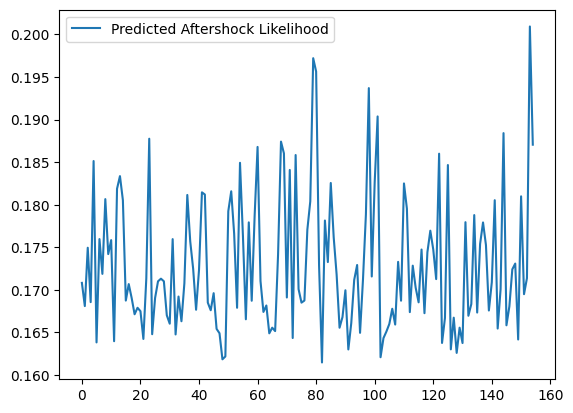

In [23]:
import matplotlib.pyplot as plt
plt.plot(predictions, label='Predicted Aftershock Likelihood')
plt.legend()
plt.show()